# Stock Prices Prediction II


## Overview

Let's take the LSTM previous model as reference and build extra models


### Load Basic Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,pandas,skmultilearn -g

import os
import sys
import re
from tqdm import tqdm
import yaml
import watermark
from math import floor
from random import random
from pprint import pprint as pp
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import pandas_profiling
from pandas.plotting import register_matplotlib_converters    # for pandas_profiling

from sklearn.preprocessing import MinMaxScaler                # data normalization

register_matplotlib_converters()                              # for pandas_profiling
sys.path.append(os.pardir)
# Set figure size
rcParams['figure.figsize'] = 20,14

from src.ts_func import add_datepart, test_stationarity


CPython 3.7.3
IPython 7.5.0

numpy 1.16.4
pandas 0.24.2
skmultilearn unknown

compiler   : GCC 7.3.0
system     : Linux
release    : 5.0.0-29-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 966669261cbed24d4e42c20eb6bb7993c9fb06ed


### Constants

In [2]:
INPUT_DATA_MMM = "../data/raw/MMM.csv"

### Load and summarize data

As we want it to be a time series we specify the format of the date and load it as index:

In [4]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv(
    INPUT_DATA_MMM, 
    parse_dates=['Date'],    # specifies the column which contains the date-time information
    date_parser=dateparse,   # Specifies a function which converts an input string into datetime variable.
    index_col='Date')

df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12360 entries, 1970-08-25 to 2019-08-23
Data columns (total 6 columns):
Open         12360 non-null float64
High         12360 non-null float64
Low          12360 non-null float64
Close        12360 non-null float64
Adj Close    12360 non-null float64
Volume       12360 non-null int64
dtypes: float64(5), int64(1)
memory usage: 675.9 KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-08-25,5.390625,5.453125,5.351563,5.437500,0.340982,416000
1970-08-26,5.437500,5.492188,5.429688,5.437500,0.340982,283200
1970-08-27,5.437500,5.515625,5.437500,5.484375,0.343921,160000


In [5]:
df.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-08-21,162.690002,163.649994,161.050003,161.149994,161.149994,1623600
2019-08-22,162.000000,162.929993,160.149994,160.880005,160.880005,1441600
2019-08-23,160.080002,160.350006,155.270004,155.850006,155.850006,4223900


In [6]:
# Sort the data by dates
df = df.sort_index(axis=0) 

In [7]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,12360.000000,12360.000000,12360.000000,12360.000000,12360.000000,1.236000e+04
mean,52.278474,52.704507,51.844152,52.290592,38.074517,2.154778e+06
std,54.630599,54.993932,54.247590,54.638248,53.237148,1.782377e+06
min,5.273438,5.328125,5.257813,5.273438,0.330694,3.520000e+04
25%,9.796875,9.875000,9.703125,9.796875,0.848003,8.944000e+05
50%,27.921875,28.125000,27.625000,27.906250,11.469022,1.809200e+06
75%,78.412502,79.092497,77.667503,78.360001,55.883679,2.884150e+06
max,258.510010,259.769989,255.970001,258.630005,245.844299,2.911600e+07


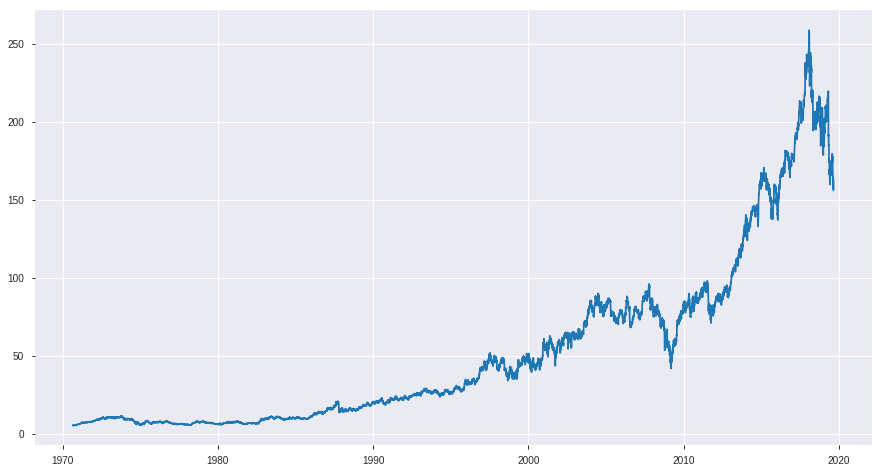

In [8]:
plt.figure(figsize=(15, 8))
plt.plot(df['Close'], label='Close Price history');

Now we have transformed the series into a stationary serie.

Divide into train and test sets.

In [9]:
n_tr = int(0.8 * df.shape[0])
df_tr = df[:n_tr].copy()
df_te = df[n_tr:].copy()

print(f'Total: {df.shape} \nTrain: {df_tr.shape} \nTest: {df_te.shape}')

Total: (12360, 6) 
Train: (9888, 6) 
Test: (2472, 6)


## **7. Long Short Term Memory (LSTM)**

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates:

* The input gate: The input gate adds information to the cell state
* The forget gate: It removes the information that is no longer required by the model
* The output gate: Output Gate at LSTM selects the information to be shown as output




In [10]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# We only need in the dataset the value to predict and the date
data = df[['Close']].copy()

# Define train and test sets
dataset = data.values

df_tr = dataset[:n_tr]
df_te = dataset[n_tr:]

# Converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(df_tr)):
    x_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

Using TensorFlow backend.


In [ ]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=100))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = data[len(data) - len(df_te) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1], 1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1


In [ ]:
# RMSE
rmse = np.sqrt(np.mean(np.power((df_te - closing_price),2)))
print(f'RMSE: {round(rmse, 3)}')

In [ ]:
df_train = data[:n_tr].copy()
df_test = data[n_tr:].copy()
df_test.loc[:, 'Predictions'] = closing_price

plt.figure(figsize=(15, 8))
plt.plot(df_train['Close']);
plt.plot(df_test[['Close','Predictions']]);

The LSTM model can be tuned for various parameters such as changing the number of LSTM layers, adding dropout value or increasing the number of epochs. But are the predictions from LSTM enough to identify whether the stock price will increase or decrease? Certainly not!

As I mentioned at the start of the article, stock price is affected by the news about the company and other factors like demonetization or merger/demerger of the companies. There are certain intangible factors as well which can often be impossible to predict beforehand.

In [43]:
df_train.columns

Index(['Close'], dtype='object')